# QG Height Tendency Equation

In [1]:
import warnings
warnings.filterwarnings('ignore', 'numpy.dtype size changed')
warnings.filterwarnings( 'ignore', category=FutureWarning)

from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import metpy.constants as mpconstants
from metpy.units import units
import numpy as np
from pyproj import Proj
from scipy.ndimage import gaussian_filter
import xarray as xr

In [2]:
date = datetime(2008,2,9,18)

ds = xr.open_dataset('http://www.ncei.noaa.gov/thredds/dodsC/gfs-g4-anl-files/'
                     '{0:%Y%m}/{0:%Y%m%d}/gfsanl_4_{0:%Y%m%d}_{0:%H}00_000.grb2'.format(date))

#ds = xr.open_dataset('groundhogs_day_blizzard/GFS_{0:%Y%m%d}_{0:%H}00.nc'.format(date))

lats = ds.lat.data
lons = cutil.add_cyclic_point(ds.lon.data)

# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(400,701)
lat_slice = slice(10,160)

lat1d = lats[lat_slice]
lon1d = lons[lon_slice]
lons, lats = np.meshgrid(lon1d, lat1d)

dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

hght_500 = ds['Geopotential_height_isobaric'].sel(isobaric3=50000).data[0, lat_slice, lon_slice]
uwnd_500 = (ds['u-component_of_wind_isobaric'].sel(isobaric3=50000).data[0, lat_slice, lon_slice]) * units('m/s')
vwnd_500 = (ds['v-component_of_wind_isobaric'].sel(isobaric3=50000).data[0, lat_slice, lon_slice]) * units('m/s')

tmpk_700 = (ds['Temperature_isobaric'].sel(isobaric3=70000).data[0, lat_slice, lon_slice]) * units.K
uwnd_700 = (ds['u-component_of_wind_isobaric'].sel(isobaric3=70000).data[0, lat_slice, lon_slice]) * units('m/s')
vwnd_700 = (ds['v-component_of_wind_isobaric'].sel(isobaric3=70000).data[0, lat_slice, lon_slice]) * units('m/s')

tmpk_300 = (ds['Temperature_isobaric'].sel(isobaric3=30000).data[0, lat_slice, lon_slice]) * units.K
uwnd_300 = (ds['u-component_of_wind_isobaric'].sel(isobaric3=30000).data[0, lat_slice, lon_slice]) * units('m/s')
vwnd_300 = (ds['v-component_of_wind_isobaric'].sel(isobaric3=30000).data[0, lat_slice, lon_slice]) * units('m/s')

vtime = datetime.strptime(str(ds.Geopotential_height_isobaric.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))
datacrs = ccrs.PlateCarree()

# Transform Coordinates ahead of time
tlatlons = mapcrs.transform_points(ccrs.PlateCarree(), lons, lats)
clons = tlatlons[:,:,0]
clats = tlatlons[:,:,1]

In [3]:
hght_500s = mpcalc.smooth_n_point(hght_500, 9, 80)
uwnd_500s = mpcalc.smooth_n_point(uwnd_500, 9, 80)
vwnd_500s = mpcalc.smooth_n_point(vwnd_500, 9, 80)

tmpk_700s = mpcalc.smooth_n_point(tmpk_700, 9, 80)
uwnd_700s = mpcalc.smooth_n_point(uwnd_700, 9, 80)
vwnd_700s = mpcalc.smooth_n_point(vwnd_700, 9, 80)

tmpk_300s = mpcalc.smooth_n_point(tmpk_300, 9, 80)
uwnd_300s = mpcalc.smooth_n_point(uwnd_300, 9, 80)
vwnd_300s = mpcalc.smooth_n_point(vwnd_300, 9, 80)

In [4]:
sigma = 2.0e-6 * units('m^2 Pa^-2 s^-2')
f0 = 1e-4 * units('s^-1')
Rd = mpconstants.Rd

avor_500 = mpcalc.absolute_vorticity(uwnd_500s, vwnd_500s, dx, dy, lats * units('degrees'),
                                     dim_order='yx')
vortadv_500 = mpcalc.advection(avor_500, (uwnd_500s, vwnd_500s), (dx, dy), dim_order='yx').to_base_units()

term_A = f0 * vortadv_500

tadv_700 = mpcalc.advection(tmpk_700s, (uwnd_700s, vwnd_700s), (dx, dy), dim_order='yx').to_base_units()
tadv_300 = mpcalc.advection(tmpk_300s, (uwnd_300s, vwnd_300s), (dx, dy), dim_order='yx').to_base_units()

diff_tadv = ((Rd/(700 * units.hPa)*tadv_700 - Rd/(300 * units.hPa)*tadv_300)/(400 * units.hPa)).to_base_units()

term_B = (-f0**2/sigma*diff_tadv).to_base_units()

In [5]:
clevs_700_tmpc = np.arange(-40, 41, 2)
clevs_500_hght = np.arange(0, 8000, 60)
clevs_QGHT = np.arange(-8, 8.5, 0.5)

wind_slice = (slice(None, None, 5), slice(None, None, 5))

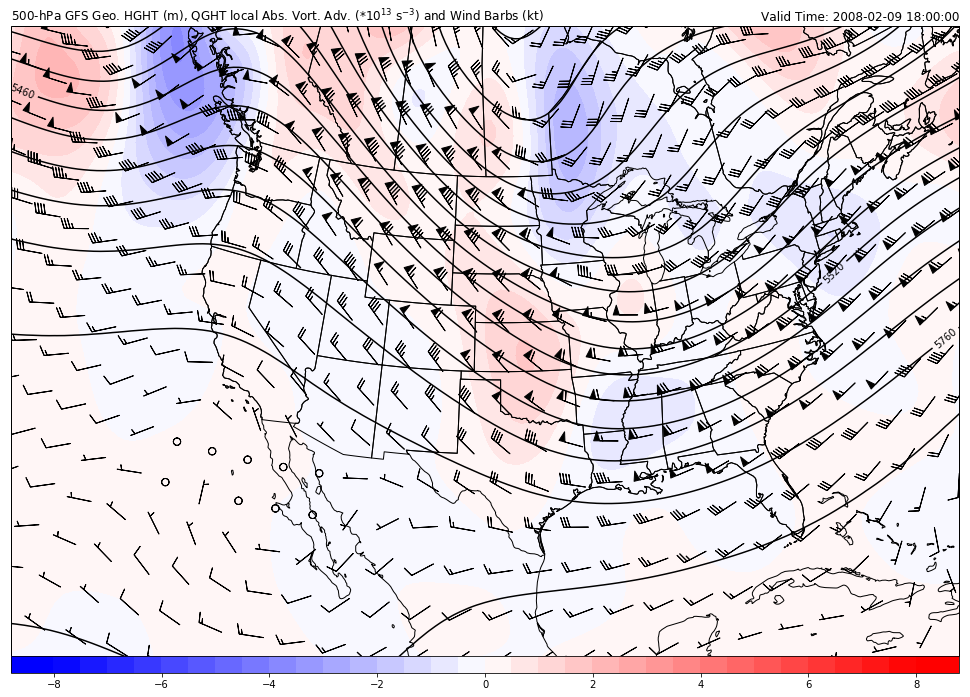

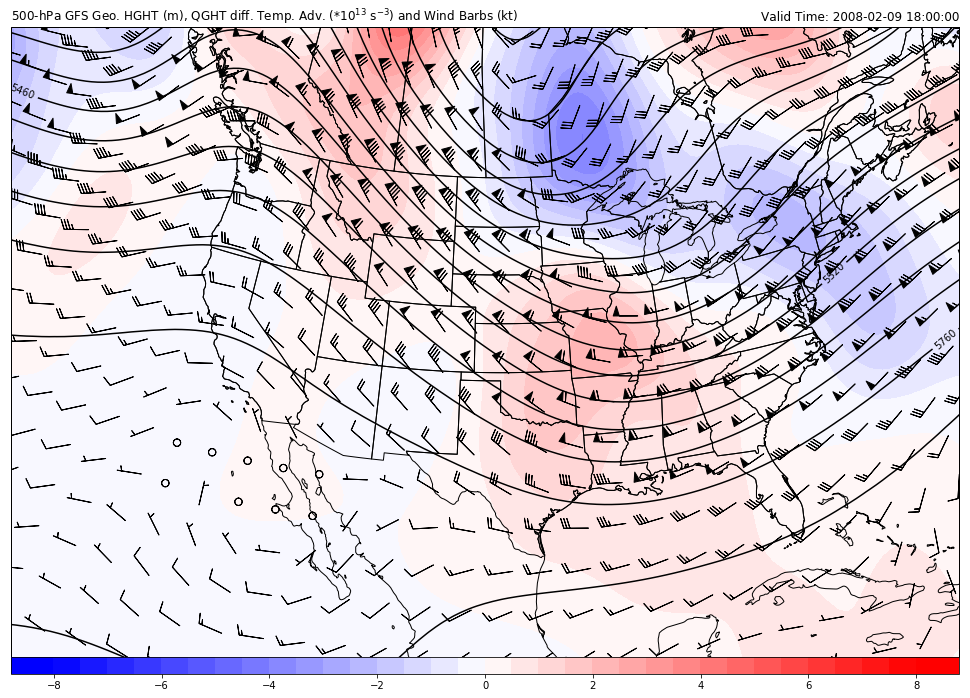

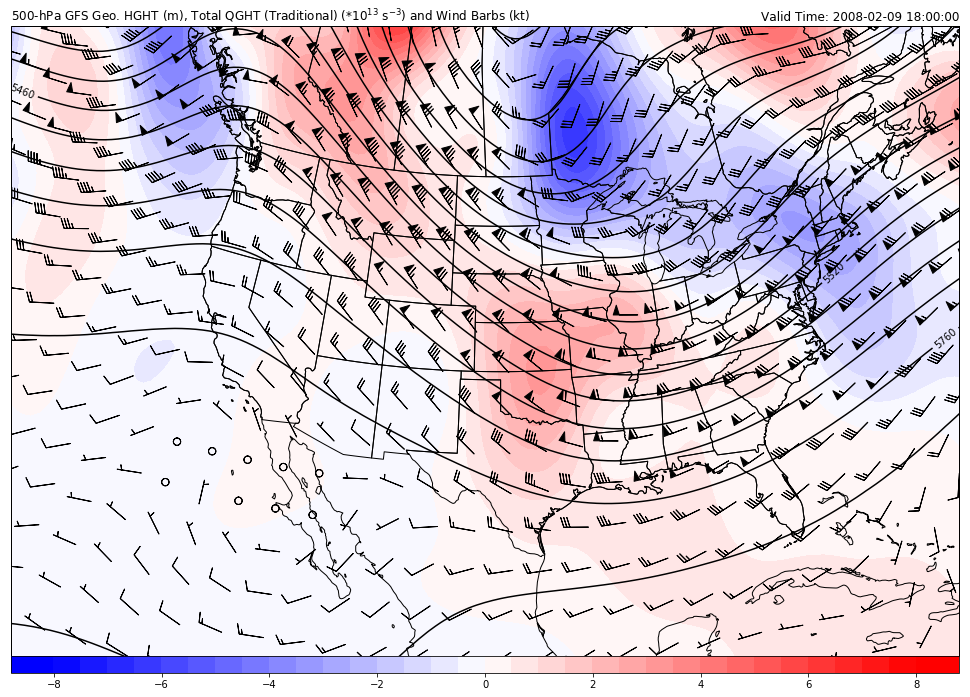

In [7]:
# 1st image
fig = plt.figure(1, figsize=(17,15))
ax1 = plt.subplot(111, projection=mapcrs)
ax1.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.STATES.with_scale('50m'))

cf = ax1.contourf(clons, clats, -term_A*1e13, clevs_QGHT, cmap=plt.cm.bwr, extend='both')
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)

cs = ax1.contour(clons, clats, hght_500s, clevs_500_hght, colors='black')
plt.clabel(cs, fmt='%d')

ax1.barbs(lons[wind_slice], lats[wind_slice],
          uwnd_500s.to('kt')[wind_slice].m, vwnd_500s[wind_slice].to('kt').m, pivot='middle',
          color='black', transform=ccrs.PlateCarree())

plt.title('500-hPa GFS Geo. HGHT (m), QGHT local Abs. Vort. Adv. '
          '($*10^{13}$ s$^{-3}$) and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.tight_layout()
plt.savefig('QGHT_Vort_{0:%Y%m%d_%H}00.png'.format(date))
plt.show()

# 2nd image
fig = plt.figure(1, figsize=(17,15))
ax2 = plt.subplot(111, projection=mapcrs)
ax2.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.STATES.with_scale('50m'))

cf = ax2.contourf(clons, clats, -term_B*1e13, clevs_QGHT, cmap=plt.cm.bwr, extend='both')
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)

cs = ax2.contour(clons, clats, hght_500s, clevs_500_hght, colors='black')
plt.clabel(cs, fmt='%d')

ax2.barbs(lons[wind_slice], lats[wind_slice],
         uwnd_500s.to('kt')[wind_slice].m, vwnd_500s[wind_slice].to('kt').m, pivot='middle',
         color='black', transform=ccrs.PlateCarree())

plt.title('500-hPa GFS Geo. HGHT (m), QGHT diff. Temp. Adv. '
          '($*10^{13}$ s$^{-3}$) and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.tight_layout()
plt.savefig('QGHT_Temp_{0:%Y%m%d_%H}00.png'.format(date))
plt.show()

# 3rd image
fig = plt.figure(1, figsize=(17,15))
ax3 = plt.subplot(111, projection=mapcrs)
ax3.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax3.add_feature(cfeature.STATES.with_scale('50m'))

cf = ax3.contourf(clons, clats, -(term_A+term_B)*1e13, clevs_QGHT, cmap=plt.cm.bwr, extend='both')
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)

cs = ax3.contour(clons, clats, hght_500s, clevs_500_hght, colors='black')
plt.clabel(cs, fmt='%d')

ax3.barbs(lons[wind_slice], lats[wind_slice],
         uwnd_500s.to('kt')[wind_slice].m, vwnd_500s[wind_slice].to('kt').m, pivot='middle',
         color='black', transform=ccrs.PlateCarree())

plt.title('500-hPa GFS Geo. HGHT (m), Total QGHT (Traditional) '
          '($*10^{13}$ s$^{-3}$) and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.savefig('QGHT_Total_{0:%Y%m%d_%H}00.png'.format(date))
plt.show()